In [1]:
from text2features_paths import FEATURE_PIPELINE_RESOURCES
from utils import DATA_DIR
import pandas as pd
from text2features import FeatureExtractorPipeline

feature_extractor = FeatureExtractorPipeline(resources=FEATURE_PIPELINE_RESOURCES)

/home/terra/Projects/vis-desc/modules/lab/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-02 21:59:34.248422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762117174.276347  538123 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762117174.284298  538123 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-02 21:59:34.312338: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in p

using device cpu


In [2]:
ds_small_labeled_path = DATA_DIR / "datasets" / "small" / "agreed.csv"
ds_small = pd.read_csv(ds_small_labeled_path, sep="\t", dtype={"label": int})

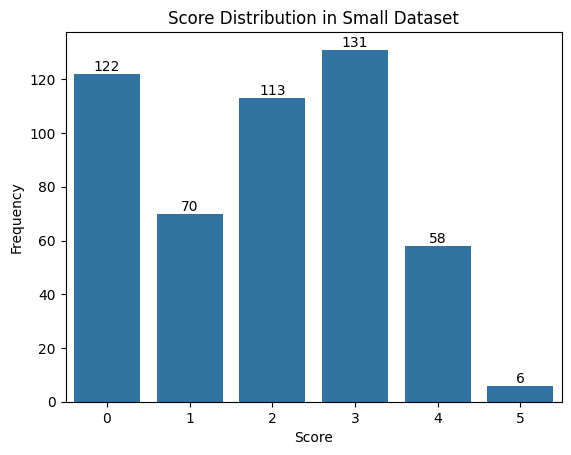

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ds_small.drop(columns=["segment_id", "annotator_1", "annotator_2"], inplace=True)
ds_small.rename(columns={"agreed_rating": "label"}, inplace=True)

# Drop rows without label
ds_small = ds_small.dropna(subset=["label"])

# Plot label distribution
ax = sns.countplot(x="label", data=ds_small)
ax.bar_label(ax.containers[0])
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Score Distribution in Small Dataset")
plt.show()

In [4]:
# Add column for feature vectors
ds_small["features"] = [feature_extractor.extract(text) for text in ds_small["text"]]

ds_small.to_parquet(DATA_DIR / "datasets" / "small" / "agreed.parquet", index=False)

In [7]:
# Compute and print dataset statistics
# - token count
# - sentence count
# - average sentence length
# - average document character length
# - average document token count
# - vocabulary size (unique tokens)

import numpy as np
from tqdm import tqdm

total_token_count = 0
total_sentence_count = 0
total_sent_length = 0
total_vocab = set()

# Lists to store per-document values for std calculation
doc_token_counts = []
doc_sentence_counts = []
doc_char_lengths = []
doc_sent_lengths = []

for index, row in tqdm(
    ds_small.iterrows(), total=len(ds_small), desc="Computing statistics"
):
    text = row["text"]
    ctx = feature_extractor.get_ctx(text)

    token_count = len(ctx.tokens)
    sentence_count = len(ctx.sents)

    total_token_count += token_count
    total_sentence_count += sentence_count
    sent_length = sum(len(sent.get_tokens()) for sent in ctx.sents)
    total_sent_length += sent_length
    lemmas = [token.lemma for token in ctx.tokens]
    total_vocab.update(lemmas)

    # Store per-document values
    doc_token_counts.append(token_count)
    doc_sentence_counts.append(sentence_count)
    doc_char_lengths.append(len(text))
    doc_sent_lengths.append(sent_length)

avg_token_count = total_token_count / len(ds_small)
avg_sentence_count = total_sentence_count / len(ds_small)
avg_sentence_length = total_sent_length / total_sentence_count
vocab_size = len(total_vocab)
ds_small["char_length"] = ds_small["text"].apply(len)
avg_char_length = ds_small["char_length"].mean()

# Calculate standard deviations
std_token_count = np.std(doc_token_counts)
std_sentence_count = np.std(doc_sentence_counts)
std_char_length = np.std(doc_char_lengths)
std_sent_length = np.std(doc_sent_lengths)

print("Overall SMALL dataset statistics:")
print("-------------------------------")
print("Dataset size:", len(ds_small))
print(f"Total token count: {total_token_count}")
print(f"Total sentence count: {total_sentence_count}")
print(f"Total vocabulary size (unique tokens): {vocab_size}")
print(f"Doc. avg character length: {avg_char_length:.2f} ± {2 * std_char_length:.2f}")
print(f"Doc. avg token count: {avg_token_count:.2f} ± {2 * std_token_count:.2f}")
print(
    f"Doc. avg sentence count: {avg_sentence_count:.2f} ± {2 * std_sentence_count:.2f}"
)
print(
    f"Doc. avg sentence length: {avg_sentence_length:.2f} ± {2 * std_sent_length:.2f}"
)

Computing statistics: 100%|██████████| 500/500 [00:36<00:00, 13.52it/s]

Overall SMALL dataset statistics:
-------------------------------
Dataset size: 500
Total token count: 29876
Total sentence count: 1528
Total vocabulary size (unique tokens): 4467
Doc. avg character length: 270.10 ± 210.09
Doc. avg token count: 59.75 ± 45.45
Doc. avg sentence count: 3.06 ± 3.48
Doc. avg sentence length: 19.79 ± 45.85


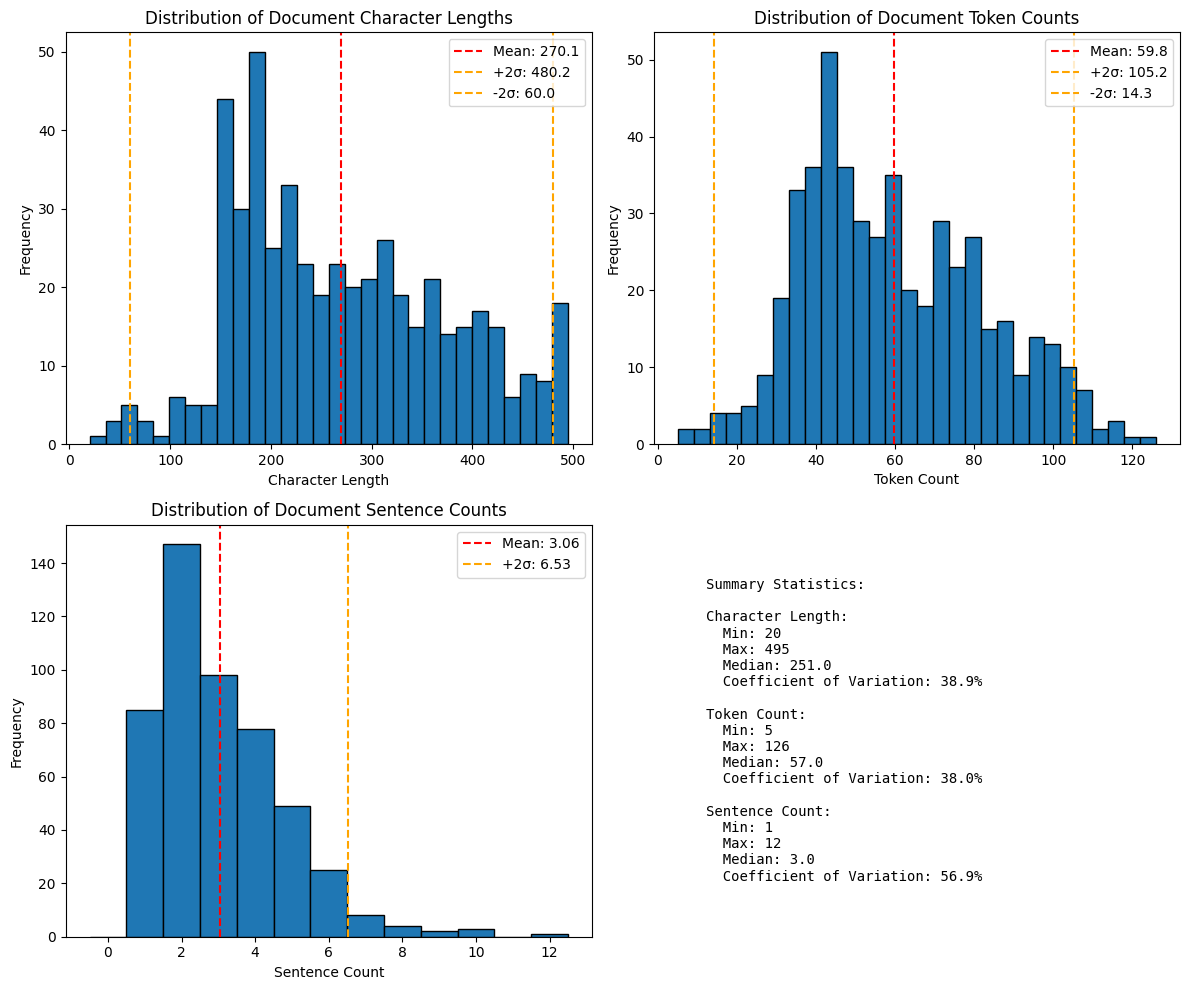


Coefficient of Variation (CV = std/mean):
Character length CV: 38.9%
Token count CV: 38.0%
Sentence count CV: 56.9%

Note: CV > 100% indicates very high variability (std > mean)


In [6]:
# Analyze the distribution of document statistics to check for outliers
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Character length distribution
axes[0, 0].hist(doc_char_lengths, bins=30, edgecolor="black")
axes[0, 0].axvline(
    avg_char_length, color="r", linestyle="--", label=f"Mean: {avg_char_length:.1f}"
)
axes[0, 0].axvline(
    avg_char_length + 2 * std_char_length,
    color="orange",
    linestyle="--",
    label=f"+2σ: {avg_char_length + 2 * std_char_length:.1f}",
)
axes[0, 0].axvline(
    avg_char_length - 2 * std_char_length,
    color="orange",
    linestyle="--",
    label=f"-2σ: {avg_char_length - 2 * std_char_length:.1f}",
)
axes[0, 0].set_xlabel("Character Length")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Distribution of Document Character Lengths")
axes[0, 0].legend()

# Token count distribution
axes[0, 1].hist(doc_token_counts, bins=30, edgecolor="black")
axes[0, 1].axvline(
    avg_token_count, color="r", linestyle="--", label=f"Mean: {avg_token_count:.1f}"
)
axes[0, 1].axvline(
    avg_token_count + 2 * std_token_count,
    color="orange",
    linestyle="--",
    label=f"+2σ: {avg_token_count + 2 * std_token_count:.1f}",
)
axes[0, 1].axvline(
    avg_token_count - 2 * std_token_count,
    color="orange",
    linestyle="--",
    label=f"-2σ: {avg_token_count - 2 * std_token_count:.1f}",
)
axes[0, 1].set_xlabel("Token Count")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_title("Distribution of Document Token Counts")
axes[0, 1].legend()

# Sentence count distribution
axes[1, 0].hist(
    doc_sentence_counts,
    bins=range(0, max(doc_sentence_counts) + 2),
    edgecolor="black",
    align="left",
)
axes[1, 0].axvline(
    avg_sentence_count,
    color="r",
    linestyle="--",
    label=f"Mean: {avg_sentence_count:.2f}",
)
axes[1, 0].axvline(
    avg_sentence_count + 2 * std_sentence_count,
    color="orange",
    linestyle="--",
    label=f"+2σ: {avg_sentence_count + 2 * std_sentence_count:.2f}",
)
axes[1, 0].set_xlabel("Sentence Count")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_title("Distribution of Document Sentence Counts")
axes[1, 0].legend()

# Summary statistics table
axes[1, 1].axis("off")
summary_text = f"""
Summary Statistics:

Character Length:
  Min: {min(doc_char_lengths)}
  Max: {max(doc_char_lengths)}
  Median: {np.median(doc_char_lengths):.1f}
  Coefficient of Variation: {(std_char_length / avg_char_length) * 100:.1f}%

Token Count:
  Min: {min(doc_token_counts)}
  Max: {max(doc_token_counts)}
  Median: {np.median(doc_token_counts):.1f}
  Coefficient of Variation: {(std_token_count / avg_token_count) * 100:.1f}%

Sentence Count:
  Min: {min(doc_sentence_counts)}
  Max: {max(doc_sentence_counts)}
  Median: {np.median(doc_sentence_counts):.1f}
  Coefficient of Variation: {(std_sentence_count / avg_sentence_count) * 100:.1f}%
"""
axes[1, 1].text(
    0.1, 0.5, summary_text, fontsize=10, verticalalignment="center", family="monospace"
)

plt.tight_layout()
plt.show()

print("\nCoefficient of Variation (CV = std/mean):")
print(f"Character length CV: {(std_char_length / avg_char_length) * 100:.1f}%")
print(f"Token count CV: {(std_token_count / avg_token_count) * 100:.1f}%")
print(f"Sentence count CV: {(std_sentence_count / avg_sentence_count) * 100:.1f}%")
print("\nNote: CV > 100% indicates very high variability (std > mean)")